___
## Springboard Capstone 1: Liver Disease Prediction
### Learning Model Comparison with Data Preprocessing and Dimensionality Reduction

Nils Madsen
___

### Overview of Rationale and Approach

The predictors in this problem are continuous, quantitative variables (with the exception of sex). As can be seen in the data storytelling, there is some degree of covariance among different variables. In order to mitigate the effect of this covariance on the success of the learning models (especially logistic regression), it would be best to produce a set of uncorrelated predictor variables.

Principal Component Analysis (PCA) is a common and effective tool for returning derived variables (components) that are uncorrelated. PCA also has the benefit of allowing for dimensionality reduction while keeping most of the information in the dataset, which may improve the performance of the learning models. 

However, correct implementation of PCA requires that the data be unskewed, centered, and equally scaled between variables. The overall strategy here will be:

1. Unskew the data using various transformations 

2. Standardize the data

3. Use PCA to produce uncorrelated variables, possibly with dimensionality reduction

4. Train various learning models, evaluating the effectiveness of each with cross-validation

5. Get an idea for the performance of the model(s) on new data by applying the trained model(s) to the test dataset
___

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style('whitegrid')

In [2]:
# import cleaned data
liver_df = pd.read_csv('indian_liver_dataset_clean.csv', index_col=0)
print(liver_df.info())

# convert sex and disease group variables to numeric form
liver_df.sex = liver_df.sex.map({'Male': 1, 'Female': 0})
liver_df['liver disease'] = liver_df['liver disease'].astype('int')
liver_df.head(10)

# convert sex, age, ALP, ALT, and AST to float64
liver_df.sex = liver_df.sex.astype(np.float64)
liver_df.age = liver_df.age.astype(np.float64)
liver_df.ALP = liver_df.ALP.astype(np.float64)
liver_df.ALT = liver_df.ALT.astype(np.float64)
liver_df.AST = liver_df.AST.astype(np.float64)
print(liver_df.info())
liver_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null int64
sex              583 non-null object
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null int64
ALT              583 non-null int64
AST              583 non-null int64
total protein    583 non-null float64
albumin          583 non-null float64
a-g ratio        583 non-null float64
liver disease    583 non-null bool
dtypes: bool(1), float64(5), int64(4), object(1)
memory usage: 50.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null float64
sex              583 non-null float64
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null float64
ALT              583 non-null float64
AST              583 non-null float64
total protein    583 non-null float64
alb

,age,sex,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio,liver disease
0,65.0,0.0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62.0,1.0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62.0,1.0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58.0,1.0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72.0,1.0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [3]:
# create train and test datasets
from sklearn.model_selection import train_test_split

X = liver_df.copy()
y = X.pop('liver disease')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=51)

___
### Skew correction

First, visualize and correct for skewed distributions by transforming each variable as needed. To avoid any possibility of overfitting, decisions about which transformation to use for each variable will be made solely based on the training data.
___

In [4]:
def vis_transforms(df, variable, bins=20):
    ''' Visualize distribution after skew-correcting transforms, in order of increasing strength'''
    array = np.array(df[variable])
    
    # Untransformed
    plt.hist(array, bins=bins)
    plt.title('{} - Untransformed'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(array))
    
    # Square root
    plt.hist(np.sqrt(array), bins=bins)
    plt.title('{} - Square root transformed'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(np.sqrt(array)))
    
    # Log
    plt.hist(np.log(array), bins=bins)
    plt.title('{} - Log transformed'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(np.log(array)))
    
    # Box-Cox
    bc_transformed, bestlambda = stats.boxcox(array)
    plt.hist(bc_transformed, bins=bins)
    plt.title('{} - Box-Cox transformed (lambda = {})'.format(variable, round(bestlambda,2)))
    plt.show()
    print('Skew: ', stats.skew(bc_transformed))
    
    # Reciprocal
    plt.hist(np.reciprocal(array), bins=bins)
    plt.title('{} - reciprocal transformed'.format(variable))
    plt.margins(0.1)
    plt.show()
    print('Skew: ', stats.skew(np.reciprocal(array)))

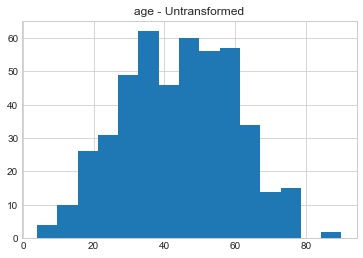

Skew:  0.007381153324696367


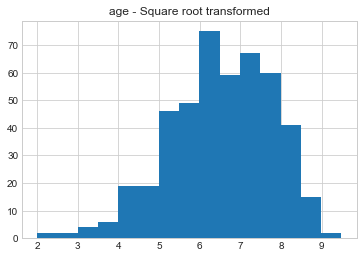

Skew:  -0.5067604995695986


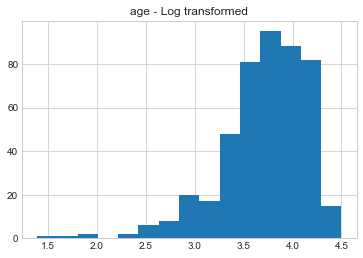

Skew:  -1.3008043863076106


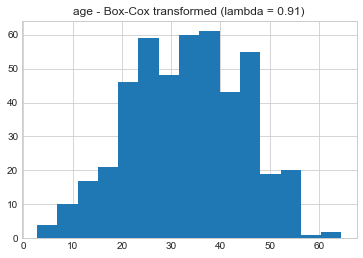

Skew:  -0.07513121172544522


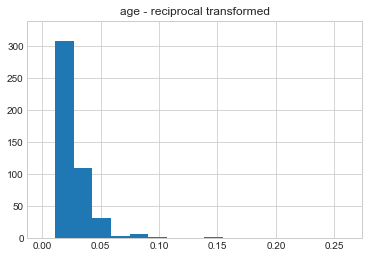

Skew:  5.519536617840287


In [5]:
# Age
vis_transforms(X_train, 'age', bins=15)

Age is not skewed in this dataset.

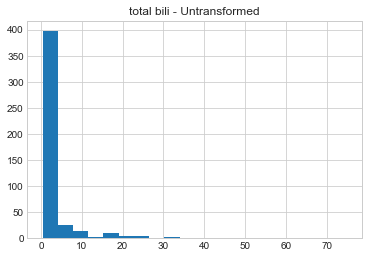

Skew:  5.382393681970029


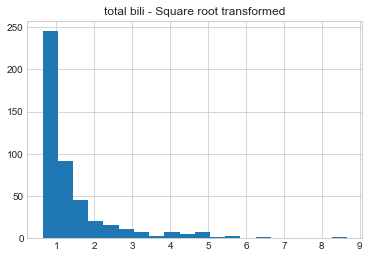

Skew:  2.753203468961275


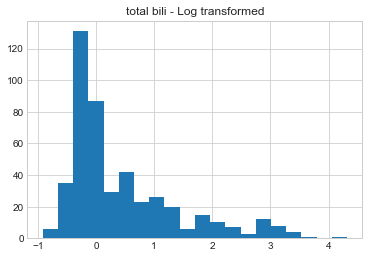

Skew:  1.4172983534598347


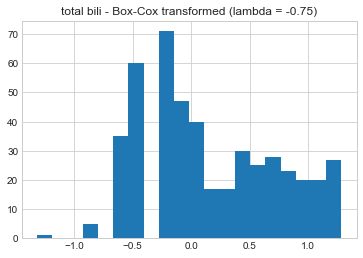

Skew:  0.3294530515879714


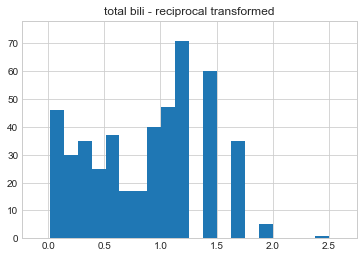

Skew:  -0.07306881708527697


In [6]:
# total bilirubin
vis_transforms(X_train, 'total bili')

Total bilirubin is heavily skewed. Reciprocal transformation returns the best result.

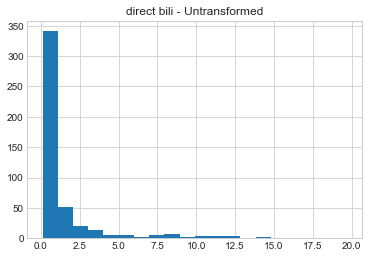

Skew:  3.407578507573229


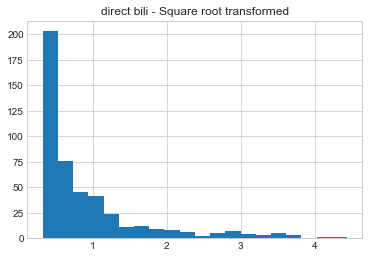

Skew:  2.1048628221742556


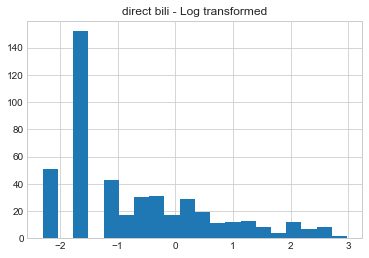

Skew:  0.8577120508557118


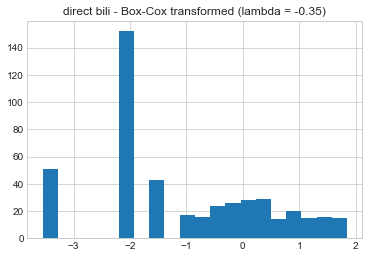

Skew:  0.16752958832959383


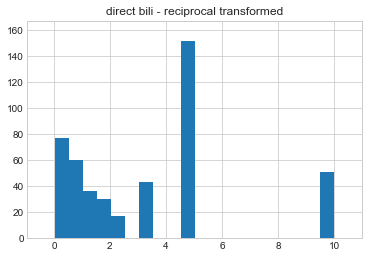

Skew:  0.8656056956445966


In [7]:
# direct bilirubin
vis_transforms(X_train, 'direct bili')

Attempting to unskew direct bili with any transformation stronger than square root causes the distribution to be broken up into discrete values. This is due to inadequate precision at lower values of direct bili (usually only to the scale of 0.1). Box-Cox transformation is the best that can be done with this variable, but it also may be best not to use this variable in the model due to the inability to adequately correct for the skew.

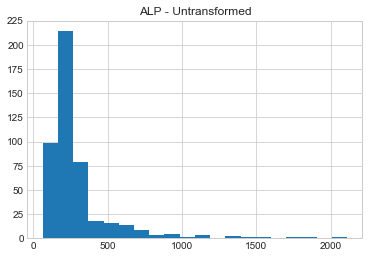

Skew:  3.758116953004775


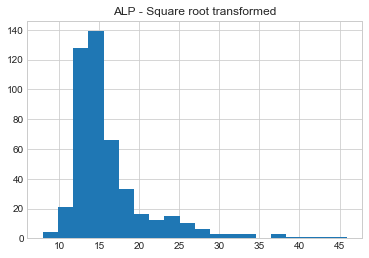

Skew:  2.369166623890703


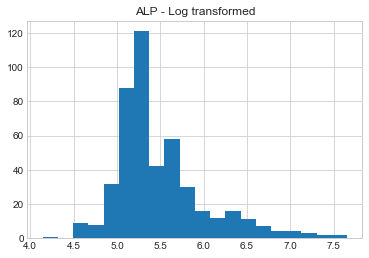

Skew:  1.30746950604503


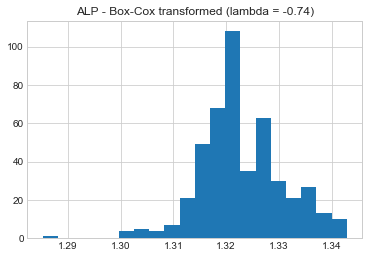

Skew:  -0.03905933473814253


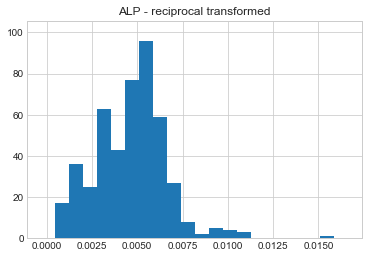

Skew:  0.5611726852374268


In [8]:
# ALP
vis_transforms(X_train, 'ALP', bins=20)

ALP is also heavily skewed, but fortunately the issue of creating discrete values at the low end does not appear here. Box-Cox transformation corrects best for the skew.

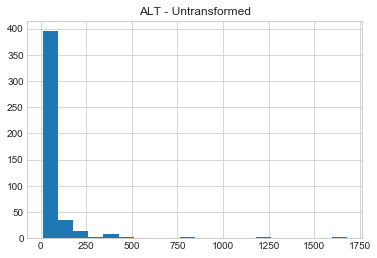

Skew:  6.133179878981283


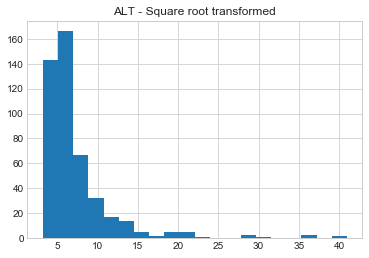

Skew:  3.627851053617077


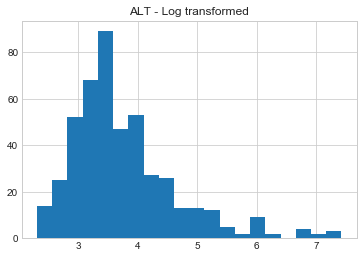

Skew:  1.4221811535870952


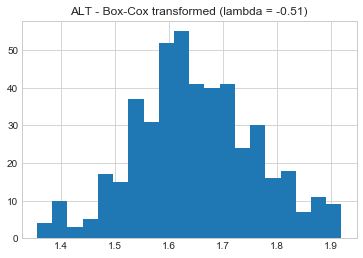

Skew:  0.06443248634191424


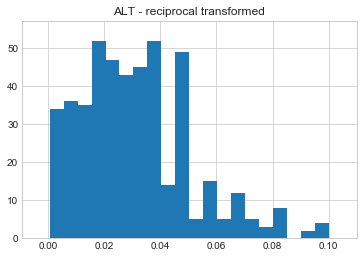

Skew:  0.860645834345854


In [9]:
# ALT
vis_transforms(X_train, 'ALT')

ALT is heavily skewed as well. Box-Cox is able to correct well for the skew.

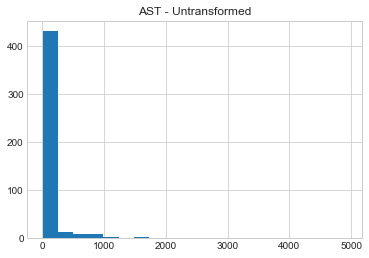

Skew:  10.995263098643422


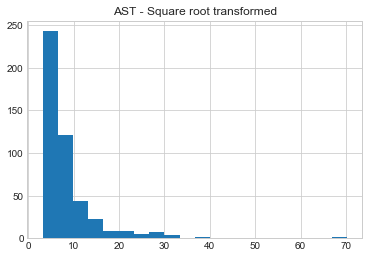

Skew:  3.848922558560591


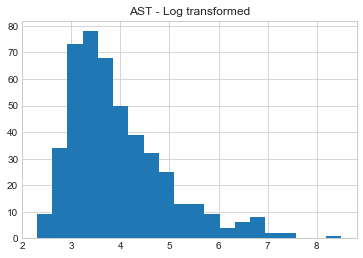

Skew:  1.2035299438071139


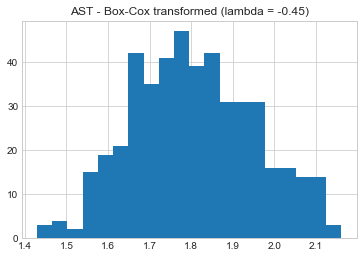

Skew:  0.10702496940195291


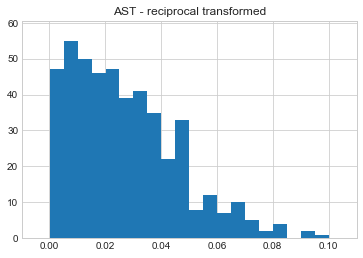

Skew:  0.8380284939197347


In [10]:
# AST
vis_transforms(X_train, 'AST')

AST is the most skewed of all variables in the dataset, but Box-Cox is able to correct well for the skew.

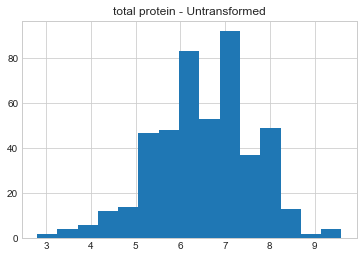

Skew:  -0.27835737859598536


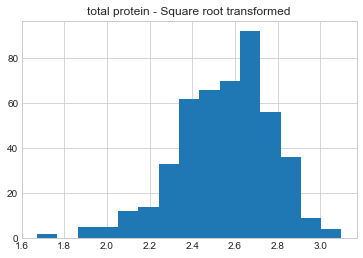

Skew:  -0.5778043349935461


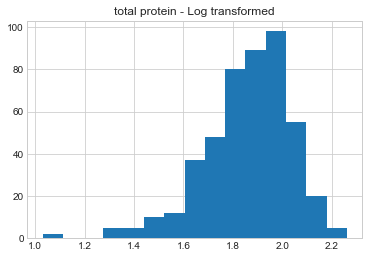

Skew:  -0.9263948926561296


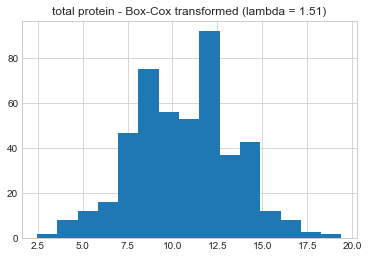

Skew:  -0.00849498477045964


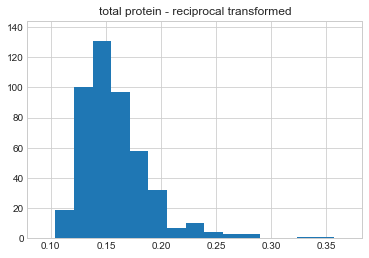

Skew:  1.8579593873003055


In [11]:
# total protein
vis_transforms(X_train, 'total protein', bins=15)

Total Protein is only mildly skewed. Box-Cox is the best transformation here as well.

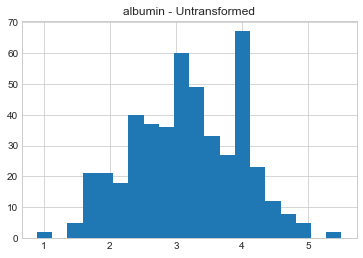

Skew:  -0.050752473379931676


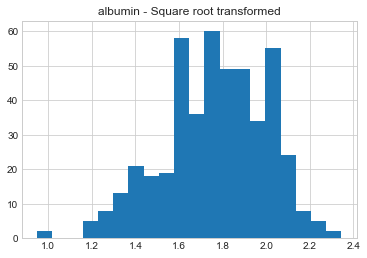

Skew:  -0.3883822632760677


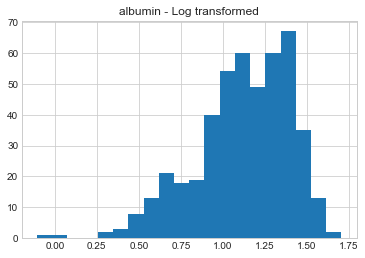

Skew:  -0.790018045915971


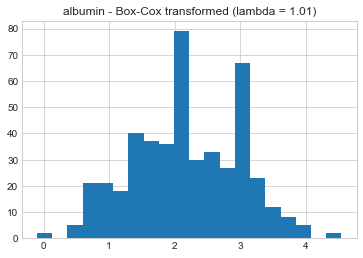

Skew:  -0.044914207722152745


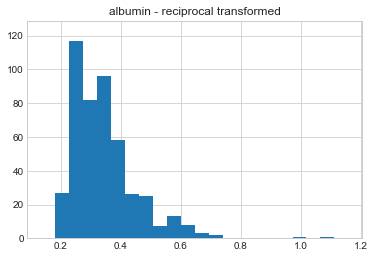

Skew:  2.0537220890490446


In [12]:
# albumin
vis_transforms(X_train, 'albumin')

Albumin is not skewed in this dataset.

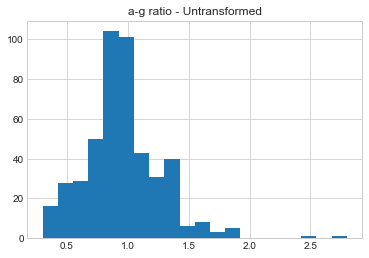

Skew:  0.9729716582627487


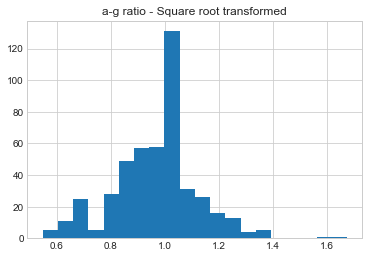

Skew:  0.17753733037030583


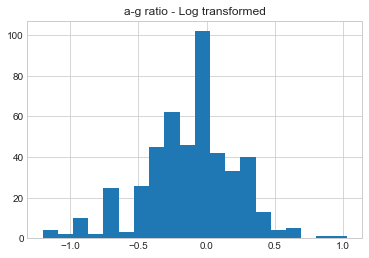

Skew:  -0.4904465289622721


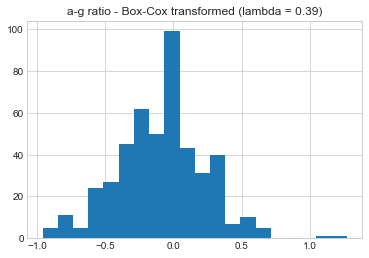

Skew:  0.03000586699258071


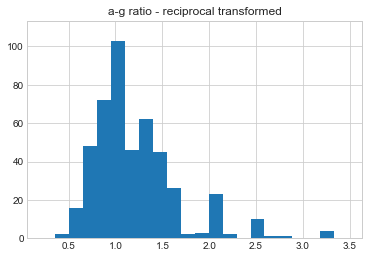

Skew:  1.782819680573373


In [13]:
# a-g ratio
vis_transforms(X_train, 'a-g ratio')

A-g ratio is slightly skewed in the data, and Box-Cox performs best to correct for this.

___
### Applying the deskewing transformations

Sklearn has not yet implemented a power-transforming object that can be used within pipelines. This feature is slated for the 0.20 release: http://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.PowerTransformer.html

As a result, the transformations here will be applied manually to the training data. Then, the parameters found to best tranform the training data will also be used to transform the test data. This is to simulate how new data will be treated in a real-world application.
___

Box-Cox transform lambdas: 
 {'direct bili': -0.3517070001175572, 'ALP': -0.7421328706437866, 'ALT': -0.5091930571744224, 'AST': -0.45296392847290656, 'total protein': 1.507101313153461, 'a-g ratio': 0.39476327262009875}


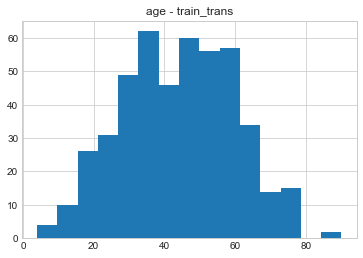

Skew:  0.007381153324696367


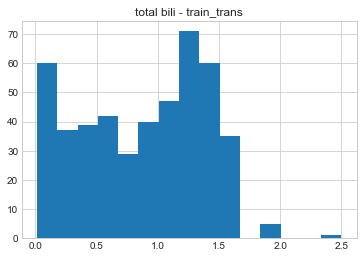

Skew:  -0.07306881708527697


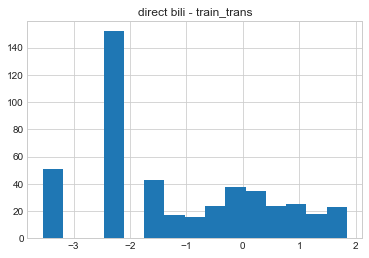

Skew:  0.16752958832959383


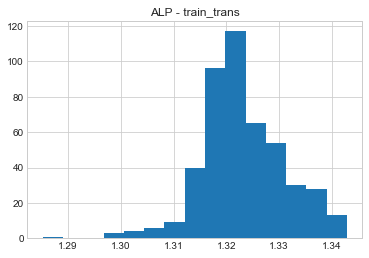

Skew:  -0.03905933473814253


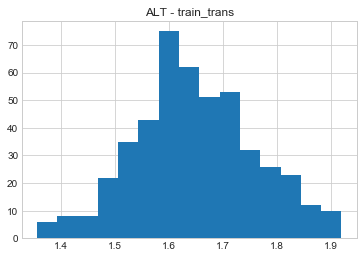

Skew:  0.06443248634191424


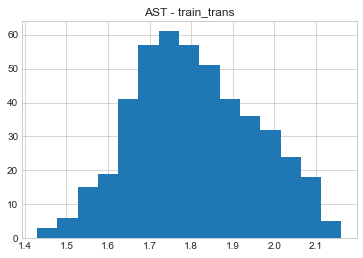

Skew:  0.10702496940195291


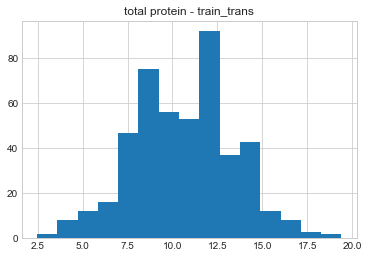

Skew:  -0.00849498477045964


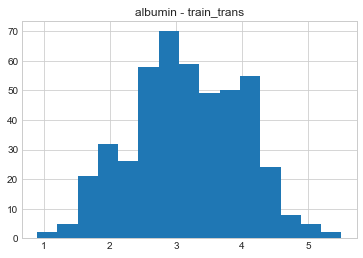

Skew:  -0.050752473379931676


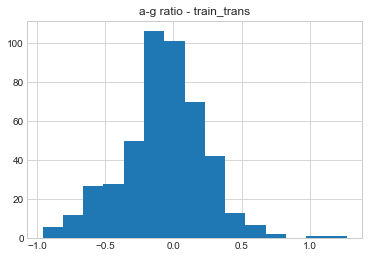

Skew:  0.03000586699258071


In [14]:
# apply best transformations to create unskewed training dataset
train_trans = X_train.copy()

train_trans['total bili'] = np.reciprocal(X_train['total bili'])

box_cox_variables = ['direct bili', 'ALP', 'ALT', 'AST', 'total protein', 'a-g ratio']
bestlambdas = dict()

for variable in box_cox_variables:
    train_trans[variable], bestlambdas[variable] = stats.boxcox(X_train[variable])

print('Box-Cox transform lambdas: \n', bestlambdas)

# visualize distributions of variables in transformed training dataset
for variable in ('age', 'total bili', 'direct bili', 'ALP', 
                 'ALT', 'AST', 'total protein', 'albumin', 'a-g ratio'):
    array = np.array(train_trans[variable])
    plt.hist(array, bins=15)
    plt.title('{} - train_trans'.format(variable))
    plt.show()
    print('Skew: ', stats.skew(array))

In [15]:
# deskew test dataset
test_trans = X_test.copy()

test_trans['total bili'] = np.reciprocal(X_test['total bili'])

for variable in box_cox_variables:
    test_trans[variable] = stats.boxcox(X_test[variable], lmbda=bestlambdas[variable])

___
### Scaling and PCA

Scaling and PCA both have corresponding pipeline-usable objects in sklearn. However, first it would be good to visualize the effect of PCA on the training data to see how the explained variance decreases with increasing dimensions.

___

In [16]:
# scale training dataset
train_scaled = train_trans.copy()
del train_scaled['sex']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns = train_scaled.columns
train_scaled = scaler.fit_transform(train_scaled)
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns = columns

train_scaled.head()

,age,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio
0,-1.699284,0.426054,-0.261443,-0.216373,-0.794473,-1.232746,0.781542,1.149603,0.863776
1,-1.573790,-0.341158,0.587432,-0.541299,-1.889793,-0.708736,1.383701,1.766786,1.137380
2,-1.636537,0.694578,-0.707401,0.507771,0.821515,1.122613,-0.960003,-0.825383,-0.396835
3,1.940038,-0.341158,0.018542,-0.067035,0.423745,-0.493305,-0.615344,-0.701946,-0.769737
4,0.873340,0.694578,-0.707401,-0.511352,-0.175153,-0.770260,1.589654,1.519913,0.575997


In [17]:
# scale test dataset
test_scaled = test_trans.copy()
del test_scaled['sex']

columns = test_scaled.columns
test_scaled = scaler.transform(test_scaled)
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = columns

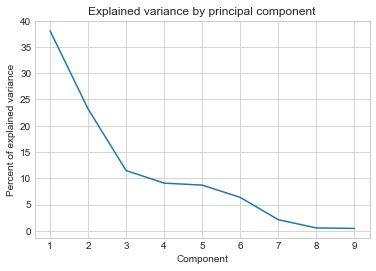

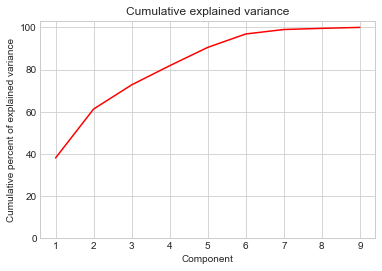

,Explained,Cumulative
Component,,
1,38.084082,38.084082
2,23.199447,61.283530
3,11.464165,72.747694
4,9.075506,81.823200
5,8.700800,90.524000
6,6.355070,96.879070
7,2.114321,98.993391
8,0.550033,99.543423
9,0.456577,100.000000


In [18]:
# perform PCA on scaled training dataset
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(train_scaled)

pca_results = pd.DataFrame(pca.explained_variance_ratio_)
pca_results.columns = ['Explained']
pca_results['Cumulative'] = np.cumsum(pca.explained_variance_ratio_)
pca_results = pca_results*100
pca_results.index = range(1, 10)
pca_results.index.name = 'Component'

# visualize results
plt.plot(pca_results['Explained'])
plt.title('Explained variance by principal component')
plt.ylabel('Percent of explained variance')
plt.xlabel('Component')
plt.show()

plt.plot(pca_results['Cumulative'], color='red')
plt.title('Cumulative explained variance')
plt.ylabel('Cumulative percent of explained variance')
plt.xlabel('Component')
plt.ylim(ymin=0)
plt.show()

pca_results

___
The results of PCA show that the first 6 components explain almost 97% of the variance, and the first 7 explain more than 99% of the variance. Since we started with 9 variables, these results show that there is at least 2-3 variables' worth of redundancy in the data due to covariance. 
___

### Logistic Regression

The first model to evaluate is logistic regression.
___

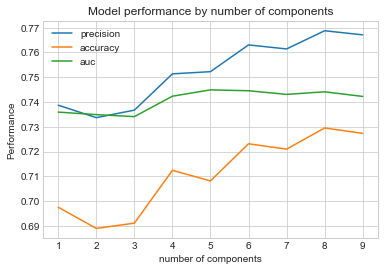

In [19]:
# evaluate model performance with various number of components
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def plot_components(model, train_scaled, X_train, y_train):
    ''' plot model performance metrics vs number of PCA components '''
    cv_scores = pd.DataFrame()

    for n_components in range(1, 10):    
        pca = PCA(n_components=n_components)
        train_pca = pca.fit_transform(train_scaled)
        train_pca = pd.DataFrame(train_pca)
        train_pca.set_index(X_train.index, inplace=True)
        train_pca['sex'] = X_train['sex']
        cv_scores.loc[n_components, 'precision'] = cross_val_score(model, X=train_pca, 
                                                                   y=y_train, cv=5, scoring='precision').mean()
        cv_scores.loc[n_components, 'accuracy'] = cross_val_score(model, X=train_pca, 
                                                                  y=y_train, cv=5, scoring='accuracy').mean()
        cv_scores.loc[n_components, 'auc'] = cross_val_score(model, X=train_pca, 
                                                             y=y_train, cv=5, scoring='roc_auc').mean()

    cv_scores.plot()
    plt.title('Model performance by number of components')
    plt.xlabel('number of components')
    plt.ylabel('Performance')
    plt.show()
    
plot_components(LogisticRegression(), train_scaled, X_train, y_train)

___
The performance of the model does seem to improve somewhat with more components, although surprisingly the model is able to perform pretty well already with just the first two components and sex. 8 components looks to yield the best result according to all three metrics.
___

In [40]:
# fit pca with 8 components
pca = PCA(n_components=8)
train_pca = pca.fit_transform(train_scaled)
train_pca = pd.DataFrame(train_pca)
train_pca.set_index(train_trans.index, inplace=True)
train_pca['sex'] = train_trans['sex']

# transform test dataset
test_pca = pca.transform(test_scaled)
test_pca = pd.DataFrame(test_pca)
test_pca.set_index(test_trans.index, inplace=True)
test_pca['sex'] = test_trans['sex']

In [32]:
# tune hyperparameters with cross-validation
from sklearn.model_selection import GridSearchCV

param_grid = {'C': np.logspace(-5, 2, 100)}

logit = LogisticRegression()
logit_grid = GridSearchCV(logit, param_grid, cv=5, return_train_score=False, scoring='precision')
logit_grid.fit(train_pca, y_train)

print(logit_grid.best_params_)
print(logit_grid.best_score_)
cv_results = pd.DataFrame(logit_grid.cv_results_)

{'C': 0.0003053855508833416}
0.8085855176058103


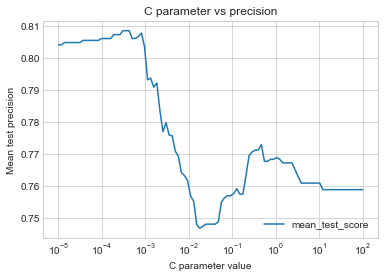

In [33]:
# plot C parameter vs precision
plt.plot(cv_results.param_C, cv_results.mean_test_score)
plt.xscale('log')
plt.title('C parameter vs precision')
plt.xlabel('C parameter value')
plt.ylabel('Mean test precision')
plt.legend(loc='lower right')
plt.show()

The model performs with high precision at C values less than 10^-3. Precision was chosen as the evaluation metric here due to the fact that this model will best serve as a rule-in test; therefore, we want to maximize the positive predictive power of the model.

In [34]:
# evaluate model performance on test data
from sklearn.metrics import confusion_matrix

logit_model = logit_grid.best_estimator_
logit_model.fit(train_pca, y_train)

logit_pred = pd.Series(logit_model.predict(test_pca))
matrix = confusion_matrix(y_test, logit_pred)

print('confusion matrix: \n', matrix)
print('accuracy: ', logit_model.score(test_pca, y_test))
print('precision: ', matrix[1, 1]/np.sum(matrix[:,1]))
print('specificity: ', matrix[0, 0]/np.sum(matrix[0,:]))
print('sensitivity: ', matrix[1, 1]/np.sum(matrix[1,:]))

confusion matrix: 
 [[18 16]
 [16 67]]
accuracy:  0.7264957264957265
precision:  0.8072289156626506
specificity:  0.5294117647058824
sensitivity:  0.8072289156626506


___
### Random Forest

The next model to try is random forest. 

Random forest is theoretically resistent to skew, scaling, and excess features, so it can possibly be trained on the original data, without preprocessing. Performance of the model will be evaluated after training on both the original and transformed data.
___

In [41]:
# optimize hyperparameters for random forest on ORIGINAL DATA
# warning: this cell is computationally intensive - do not rerun
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
params = {'n_estimators': range(100, 501, 100),
          'max_depth': [30, 50, 70, 90],
          'min_samples_leaf': [2, 3, 4, 5],
          'max_features': [None, 'auto']}
rf_grid = GridSearchCV(rf, params, cv=5, scoring='precision', n_jobs=7)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.7781999111968331
{'max_depth': 70, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 100}


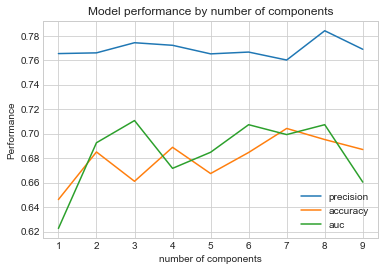

In [43]:
plot_components(RandomForestClassifier(), train_scaled, X_train, y_train)

In [ ]:
# optimize hyperparameters for random forest on TRANSFORMED DATA
# warning: this cell is computationally intensive - do not rerun

rf = RandomForestClassifier()
params = {'n_estimators': range(100, 501, 100),
          'max_depth': [30, 50, 70, 90],
          'min_samples_leaf': [2, 3, 4, 5],
          'max_features': [None, 'auto']}
rf_grid = GridSearchCV(rf, params, cv=5, scoring='precision', n_jobs=7)
rf_grid.fit(train_pca, y_train)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

In [ ]:
# evaluate model performance on test data
rf_model = rf_grid.best_estimator_
rf_model.fit(train_pca, y_train)

rf_pred = pd.Series(rf_model.predict(test_pca))
matrix = confusion_matrix(y_test, rf_pred)

print('confusion matrix: \n', matrix)
print('accuracy: ', rf_model.score(test_pca, y_test))
print('precision: ', matrix[1, 1]/np.sum(matrix[:,1]))
print('specificity: ', matrix[0, 0]/np.sum(matrix[0,:]))
print('sensitivity: ', matrix[1, 1]/np.sum(matrix[1,:]))

___
Random forest performs the best using 8 components, the same as for logistic regression. 
___

___
Random forest performs strictly worse than the logit model with regard to both precision and accuracy. Furthermore, an inspection of the confusion matrix reveals it is classifying the vast majority of subjects as having liver disease. This is not as useful a model as logit.

___
### Support Vector Machine

SVM is the next model to test. 

SVM is sensitive to scaling and skew, so the deskewed, standardized data will be used here.
___

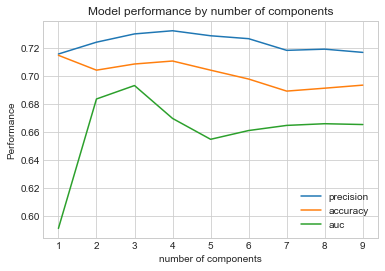

In [35]:
from sklearn.svm import SVC

# visualize effect of component number on SVM performance
plot_components(SVC(), train_scaled, X_train, y_train)

___
SVM performs best with 3 components. Precision is slightly lower for 3 components than 4, but AUC is substantially higher.
___

In [36]:
# fit pca with 3 components
pca = PCA(n_components=3)
train_pca = pca.fit_transform(train_scaled)
train_pca = pd.DataFrame(train_pca)
train_pca.set_index(train_trans.index, inplace=True)
train_pca['sex'] = train_trans['sex']

# transform test dataset
test_pca = pca.transform(test_scaled)
test_pca = pd.DataFrame(test_pca)
test_pca.set_index(test_trans.index, inplace=True)
test_pca['sex'] = test_trans['sex']

In [37]:
# tune hyperparameters with cross-validation
svm = SVC()

params = {'C': np.logspace(-2, 2, 20),
          'kernel': ['linear', 'rbf', 'sigmoid'],
          'gamma': np.logspace(-2, 2, 20)}

svm_grid = GridSearchCV(svm, params, cv=5, scoring='precision', n_jobs=7)

svm_grid.fit(train_pca, y_train)
print(svm_grid.best_params_)
print(svm_grid.best_score_)

{'C': 8.858667904100823, 'gamma': 0.06951927961775606, 'kernel': 'sigmoid'}
0.7802462027346553


In [38]:
# evaluate model performance on test data
svm_model = svm_grid.best_estimator_
svm_model.fit(train_pca, y_train)

svm_pred = pd.Series(svm_model.predict(test_pca))
matrix = confusion_matrix(y_test, svm_pred)

print('confusion matrix: \n', matrix)
print('accuracy: ', svm_model.score(test_pca, y_test))
print('precision: ', matrix[1, 1]/np.sum(matrix[:,1]))
print('specificity: ', matrix[0, 0]/np.sum(matrix[0,:]))
print('sensitivity: ', matrix[1, 1]/np.sum(matrix[1,:]))

confusion matrix: 
 [[14 20]
 [19 64]]
accuracy:  0.6666666666666666
precision:  0.7619047619047619
specificity:  0.4117647058823529
sensitivity:  0.7710843373493976


___
SVM performs better than random forest, but worse than logistic regression for both accuracy and precision.
___

___
### Voting Classifier

Each model has its weaknesses, but perhaps a classifier that calculates the majority vote among the three models can perform even better. 

A VotingClassifier class is available in sklearn, but since the models use different number of PCA components, and sex is not included in the PCA, pipelines are difficult to use here. Therefore, the voting will be calculated manually.
___

In [44]:
model_predictions = pd.DataFrame()

model_predictions['logit'] = logit_pred
model_predictions['rf'] = rf_pred
model_predictions['svm'] = svm_pred

model_predictions['sum'] = model_predictions.sum(axis=1)
model_predictions['vote'] = (model_predictions['sum'] >= 2).astype(np.int64)

matrix = confusion_matrix(y_test, model_predictions['vote'])

print('confusion matrix: \n', matrix)
print('accuracy: ', (matrix[0,0]+matrix[1,1])/np.sum(matrix))
print('precision: ', matrix[1, 1]/np.sum(matrix[:,1]))
print('specificity: ', matrix[0, 0]/np.sum(matrix[0,:]))
print('sensitivity: ', matrix[1, 1]/np.sum(matrix[1,:]))

confusion matrix: 
 [[16 18]
 [12 71]]
accuracy:  0.7435897435897436
precision:  0.797752808988764
specificity:  0.47058823529411764
sensitivity:  0.8554216867469879


___
Using a voting classification yields accuracy and precision that are better than random forest and svm, but still worse than logistic regression alone. From these results we can conclude that logistic regression by itself is the best model to use for this problem.
___